Data <br>
https://www.kaggle.com/competitions/fake-news/data <br>

train.csv: A full training dataset with the following attributes:

id: unique id for a news article <br>
title: the title of a news article <br>
author: author of the news article <br>
text: the text of the article; could be incomplete <br>
label: a label that marks the article as potentially unreliable <br>
1: unreliable <br>
0: reliable <br>

<br> test.csv: A testing training dataset with all the same attributes at train.csv without the label.
<br> submit.csv: A sample submission that you can

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier

from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# load data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
submission = pd.read_csv("submit.csv")

In [3]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [5]:
train.nunique()

id        20800
title     19803
author     4201
text      20386
label         2
dtype: int64

In [6]:
test.nunique()

id        5200
title     5056
author    1732
text      5126
dtype: int64

In [7]:
# check & drop NaN records
train.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
test.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [9]:
# fill missing values
train = train.fillna(' ')
test = test.fillna(' ')

In [10]:
train.iloc[0].values

array([0,
       'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It',
       'Darrell Lucus',
       'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chai

### Since the text column is huge, we can just use Author & Title features

### Usually by looking at Title and Author we can pretty much judge whether News is fake or not

In [11]:
# create port stemmer object
port_stem = PorterStemmer()

In [12]:
# stop words
filter_words = stopwords.words('english')

In [13]:
# preprocessing of News
def clean_text(content):
    review = re.sub('[^a-zA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [port_stem.stem(word) for word in review if not word in filter_words]
    review = ' '.join(review)
    return review

In [14]:
# Merge Author & Title column
train['content'] = train['author']+' '+train['title']
test['content'] = test['author']+' '+test['title']

In [15]:
# preprocess content column
X = train['content'].apply(clean_text)
X_test = test['content'].apply(clean_text)

In [16]:
# converting the textual data to numerical data
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X)
X_test = vectorizer.transform(X_test)

In [17]:
# Split actuals data into train & validation set
X_train, X_val, y_train, y_val = train_test_split(X, train['label'], random_state=42, test_size=0.25)

## ML Modelling

In [18]:
# ML model
lr  = LogisticRegression()
lr.fit(X_train, y_train)

# make predictions on validation set and evaluate model performance
lr_prediction = lr.predict(X_val)
print(accuracy_score(y_val, lr_prediction))
cf_matrix = confusion_matrix(y_val, lr_prediction)
# print(cf_matrix)

0.9732692307692308


In [19]:
def custom_plot_confusion_matrix(cf_matrix):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

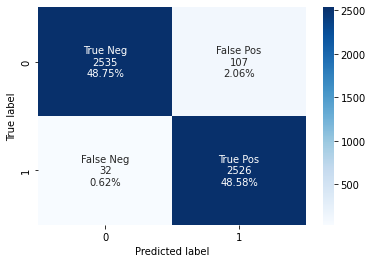

In [20]:
custom_plot_confusion_matrix(cf_matrix)

### Passive Aggressive Classifier works by responding as passive for correct classifications and responding as aggressive for any miscalculation.

In [21]:
pac = PassiveAggressiveClassifier(max_iter=50)
pac.fit(X_train, y_train)

PassiveAggressiveClassifier(max_iter=50)

In [22]:
pac_prediction = pac.predict(X_val)
print(accuracy_score(y_val, pac_prediction))
cf_matrix = confusion_matrix(y_val, pac_prediction)

0.9896153846153846


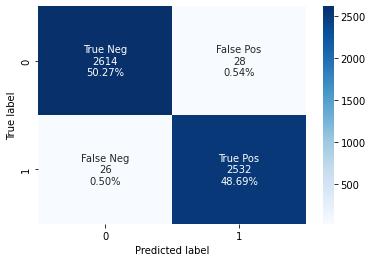

In [23]:
custom_plot_confusion_matrix(cf_matrix)

PassiveAggressiveClassifier model aggressively reduced the incorrect predictions

In [24]:
submission.head()

,id,label
0,20800,0
1,20801,1
2,20802,0
3,20803,1
4,20804,1


In [25]:
# make predictions on test set
test['label'] = pac.predict(X_test)

In [26]:
test[['id', 'label']].to_csv('final_prediction.csv', index=False)

In [27]:
# check few predictions
test.iloc[1, 1], test.iloc[1, -1]

('Russian warships ready to strike terrorists near Aleppo', 1)

In [28]:
# check few predictions
test.iloc[10, 1], test.iloc[10, -1]

('184 U.S. generals and admirals endorse Trump for Commander-In-Chief', 1)